# 2016 Road Safety - Accidents 

The goal of this report is to build a model that predicts if a police officer is likely to attend an accident or not using the accidents data provided in: https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

In [4]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

## Importing and analysing the data


In [5]:
data = pd.read_csv('Accidents_2016.csv', low_memory=False)

In [6]:
data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,...,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,2016010000005,519310.0,188730.0,-0.279323,51.584754,1,3,2,1,01/11/2016,...,0,0,5,1,1,0,0,1,1,E01000543
1,2016010000006,551920.0,174560.0,0.184928,51.449595,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01000375
2,2016010000008,505930.0,183850.0,-0.473837,51.543563,1,3,1,1,01/11/2016,...,0,0,4,1,1,0,0,1,1,E01033725
3,2016010000016,527770.0,168930.0,-0.164442,51.404958,1,3,1,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01003379
4,2016010000018,510740.0,177230.0,-0.406580,51.483139,1,3,2,1,01/11/2016,...,0,0,1,1,1,0,0,1,1,E01002583


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136621 entries, 0 to 136620
Data columns (total 32 columns):
Accident_Index                                 136621 non-null object
Location_Easting_OSGR                          136614 non-null float64
Location_Northing_OSGR                         136614 non-null float64
Longitude                                      136614 non-null float64
Latitude                                       136614 non-null float64
Police_Force                                   136621 non-null int64
Accident_Severity                              136621 non-null int64
Number_of_Vehicles                             136621 non-null int64
Number_of_Casualties                           136621 non-null int64
Date                                           136621 non-null object
Day_of_Week                                    136621 non-null int64
Time                                           136619 non-null object
Local_Authority_(District)                     136

In [8]:
data.describe()

,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,Local_Authority_(District),...,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident
count,136614.000000,1.366140e+05,136614.000000,136614.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,...,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000,136621.000000
mean,448699.363169,2.883354e+05,-1.304881,52.482399,29.860402,2.816170,1.848179,1.327644,4.115890,342.786680,...,321.590678,0.011192,0.824375,1.983509,1.553099,1.291697,0.085338,0.055409,1.352508,1.253965
std,95230.253169,1.570588e+05,1.398947,1.414390,25.252440,0.418152,0.710117,0.789296,1.917292,258.403794,...,1202.759007,0.154659,1.927500,1.676938,1.690541,0.588247,0.654925,0.557042,0.477860,0.464658
min,76702.000000,1.107500e+04,-7.389809,49.919716,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,386355.750000,1.764248e+05,-2.204357,51.473779,6.000000,3.000000,1.000000,1.000000,2.000000,102.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,454126.000000,2.374855e+05,-1.201205,52.025165,30.000000,3.000000,2.000000,1.000000,4.000000,323.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,527660.000000,3.897438e+05,-0.159708,53.401675,45.000000,3.000000,2.000000,1.000000,6.000000,516.000000,...,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.000000,0.000000,2.000000,1.000000
max,655256.000000,1.178623e+06,1.757858,60.490191,98.000000,3.000000,16.000000,58.000000,7.000000,941.000000,...,9999.000000,2.000000,8.000000,7.000000,9.000000,5.000000,7.000000,7.000000,3.000000,3.000000


## Feature Selection

Let's first simplify the column names to be able to better understand the exploratory visualizations.


In [9]:
names = ["Accident_Index","Location_Easting","Location_Northing",
         "Longitude","Latitude","Police_Force","Accident_Severity","No_of_Vehicles",
         "No_of_Casualties","Date","Day_of_Week","Time","Local_Authority_District",
         "Local_Authority_Highway","First_Road_Class","First_Road_No","Road_Type","Speed_Limit",
         "Junction_Detail","Junction_Control","Second_Road_Class","Second_Road_Number",
         "Pedestrian_Crossing_Control","Pedestrian_Crossing_Facilities",
         "Light_Conditions","Weather_Conditions","Road_Surface_Conditions","Special_Conditions_at_Site",
         "Carriageway_Hazards","Urban_or_Rural_Area","Police_Attendance","Accident_Location"]

In [10]:
data.columns = names

### Excluding features that seem unrelated to the police attendence
To get an idea about about the data, I am going to draw a heatmap of the columns. This also helps me to reduce the number of features. As it can be seen in the heatmap below, some features are highly correlated and are not mutually independent, therefore there is no use to use all of them to train the model (e.g., Location_Easting and Longitude). From the heatmap, there doesn't seem to be any meaningful correlations between the features and the police attendence.


Taking a look at the documentations of the data, and the data itself, there are some other features that can be excluded as they don't seem to have an effect on police attendence (using common sense). For example, "Accident Index" is only a unique identifier of the accident, moreover, there are some data that are mostly related to the cause of the accident itself, such as "Pedestrian Crossing Control" and "Light Conditions".

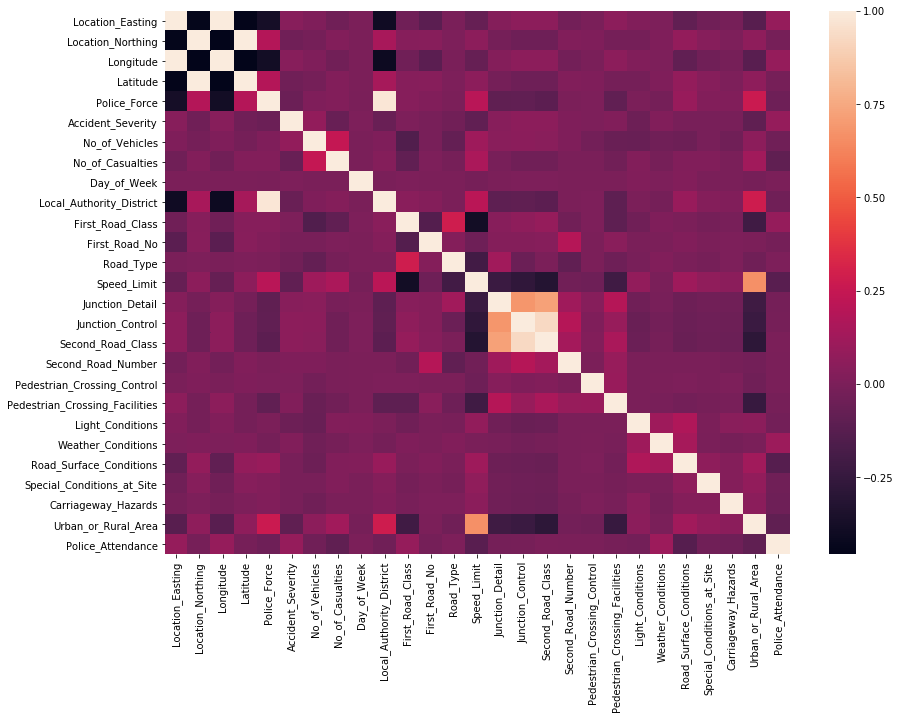

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)
ax =sns.heatmap(data.corr())

## Data preprocessing and preparation

### Handling the null values
As there are a lot of samples, to simplify the process I decided to drop the null values.

### Handling non-numerical values
There are some non-numerical values in the dataset that should be managed:
- To handle the date, I will extract the month. The day can be scaped as we already have the day of the weak included in the data set. And the year is always 2016.
- To handle the time values, I am going to extract only the hour.
- To handle non-numerical categorical values, I will convert them to numerical categories.

### Managing the target categories
The main question to be answered by the model is to predict if a police officer is likely to attend an accident or not. Looking at the police attendence field of the data there are three categories, 1 representing Yes, 2 representing No, and 3 representing No (the accident was self reported). As the goal is to predict the police attendence the target category can be simplified into a binary value.

In [12]:
data_no_na = data.dropna()

In [13]:
data_no_na['Month']=data_no_na['Date'].apply(lambda x: x.split("/")[1])
data_no_na['Hour']=data_no_na['Time'].apply(lambda x: int(x.split(":")[0]))

In [14]:
data_no_na['Accident_Location'] = data_no_na['Accident_Location'].astype('category')
data_no_na['Accident_Location_Cat'] = data_no_na['Accident_Location'].cat.codes

data_no_na['Local_Authority_Highway'] = data_no_na['Local_Authority_Highway'].astype('category')
data_no_na['Local_Authority_Highway_Cat'] = data_no_na['Local_Authority_Highway'].cat.codes

data_no_na['Police_Attendance']= data_no_na['Police_Attendance'].apply(lambda x: 1 if x==1 else 0)

In [15]:
features_minimal = data_no_na[[ 'Location_Easting', 'Location_Northing', 'Police_Force', 'Accident_Severity', 'No_of_Vehicles',
       'No_of_Casualties', 'Day_of_Week','Local_Authority_District',
       'First_Road_Class', 'First_Road_No', 'Road_Type', 'Speed_Limit',
       'Junction_Detail', 'Junction_Control', 'Second_Road_Class',
       'Second_Road_Number','Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area','Month', 'Hour','Accident_Location_Cat','Local_Authority_Highway_Cat']]

In [16]:
target = data_no_na['Police_Attendance']

## Visualize and Analyse the Results

I just use the following functions to visualize and analyse the results of the trained models

In [61]:
def plot_confusion_matrix(y_test, y_pred,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    np.set_printoptions(precision=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_side_by_side_confusion_matrix(y_test, y_pred):
    """
    Plots the confusion matrix
    """
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plot_confusion_matrix(y_test, y_pred, [0,1], normalize=False, title='Confusion Matrix')
    plt.subplot(122)
    plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True, title='Normalized Confusion Matrix')
    
def plot_roc_curve(y_test, probs):
    """
    Plots the ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, lw=1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

def plot_precision_recall_curve(y_test, probs):
    """
    Plots the Precision-Recall Curve
    """
    precision, recall, _ = precision_recall_curve(y_test, probs)
    average_precision = average_precision_score(y_test, probs)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Model Selection

First thing to consider is that here we are tackling a binary classification problem, where we have considerable amount of samples and features to train the model.

## Linear Support Vector Classification

The first model I would like to test on the data is simply the linear SVC.

Before spliting the samples into the test and train data, considering that in the samples, most of the times there have been a police attendence, the model could become biased toward this result. Therefore, it seemed that it would be better to use a technique to balance the sampling of the dataset. I used the imbalanced-learn library for this purpose that can be found here: http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html. However, the final results showed that this technique didn't improve the model in terms of the precision and recall.

To have this comparison, in the following there is the results of the trained linear SVC with the normal sampling, followed by the same model with the balanced sampling:

In [17]:
lin_svc_X_train, lin_svc_X_test, lin_svc_y_train, lin_svc_y_test = train_test_split(features_minimal, target, test_size=0.4, random_state=101)

In [18]:
lin_svc_model = svm.LinearSVC()

In [19]:
lin_svc_model.fit(lin_svc_X_train,lin_svc_y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
lin_svc_predictions = lin_svc_model.predict(lin_svc_X_test)

In [22]:
print(confusion_matrix(lin_svc_y_test,lin_svc_predictions))

[[    0 12593]
 [    0 38700]]


In [23]:
print(classification_report(lin_svc_y_test,lin_svc_predictions))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00     12593
          1       0.75      1.00      0.86     38700

avg / total       0.57      0.75      0.65     51293



C:\Users\Mahsa\Anaconda35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Now using the balanced sampling:

In [27]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(features_minimal, target)
print(sorted(Counter(y_resampled).items()))

[(0, 31589), (1, 31589)]


In [28]:
balanced_X_train, balanced_X_test, balanced_y_train, balanced_y_test = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=101)

In [29]:
lin_svc_balanced_model = svm.LinearSVC()

In [30]:
lin_svc_balanced_model.fit(balanced_X_train,balanced_y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
lin_svc_balanced_predictions = lin_svc_balanced_model.predict(balanced_X_test)

In [32]:
print(confusion_matrix(balanced_y_test,lin_svc_balanced_predictions))

[[12693     0]
 [12579     0]]


In [33]:
print(classification_report(balanced_y_test,lin_svc_balanced_predictions))

             precision    recall  f1-score   support

          0       0.50      1.00      0.67     12693
          1       0.00      0.00      0.00     12579

avg / total       0.25      0.50      0.34     25272



C:\Users\Mahsa\Anaconda35\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Improving the model using GridSearchCV
To tune the model to get better results I would use GridSearchCV on the 'C' parameter of the Linear SVC model.

In [34]:
param_grid = {'C':[1,10,100,1000]}

In [35]:
grid = GridSearchCV(svm.LinearSVC(),param_grid,verbose=3)

In [36]:
grid.fit(lin_svc_X_train,lin_svc_y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1 .............................................................
[CV] .................................... C=1, score=0.753110 -  18.0s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s


[CV] .................................... C=1, score=0.753100 -  18.2s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.2s remaining:    0.0s


[CV] .................................... C=1, score=0.250565 -  17.1s
[CV] C=10 ............................................................
[CV] ................................... C=10, score=0.753110 -  17.1s
[CV] C=10 ............................................................
[CV] ................................... C=10, score=0.753100 -  17.0s
[CV] C=10 ............................................................
[CV] ................................... C=10, score=0.753100 -  16.4s
[CV] C=100 ...........................................................
[CV] .................................. C=100, score=0.753110 -  16.8s
[CV] C=100 ...........................................................
[CV] .................................. C=100, score=0.246978 -  16.8s
[CV] C=100 ...........................................................
[CV] .................................. C=100, score=0.753100 -  16.8s
[CV] C=1000 ..........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=3)

In [37]:
grid.best_params_

{'C': 10}

In [38]:
grid_predictions = grid.predict(lin_svc_X_test)

In [39]:
print(confusion_matrix(lin_svc_y_test, grid_predictions))

[[ 2299 10294]
 [ 7688 31012]]


In [40]:
print(classification_report(lin_svc_y_test, grid_predictions))

             precision    recall  f1-score   support

          0       0.23      0.18      0.20     12593
          1       0.75      0.80      0.78     38700

avg / total       0.62      0.65      0.63     51293



## Analysing the Results

As it can be seen in the results, using the GridSearchCV to tune the 'C' parameter, the model have improved in both recall and precision.


## K-Nearest Neighbors Classification

As the results of the linear SVC model didn't seem very satisfying, I would also train a KNN classifier to compare the results. To start with, the samples should be scaled to be used for training the model.

In [41]:
scaler = StandardScaler()

In [42]:
scaler.fit(features_minimal)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [43]:
scaled_features  = scaler.transform(features_minimal)

In [44]:
knn_features = pd.DataFrame(scaled_features, columns=features_minimal.columns)

In [45]:
knn_features.head()

,Location_Easting,Location_Northing,Police_Force,Accident_Severity,No_of_Vehicles,No_of_Casualties,Day_of_Week,Local_Authority_District,First_Road_Class,First_Road_No,...,Second_Road_Number,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Month,Hour,Accident_Location_Cat,Local_Authority_Highway_Cat
0,0.683934,-0.604541,-1.260057,0.438021,0.206673,-0.4157,-0.582039,-1.269233,-0.786517,1.766259,...,-0.271706,-0.324731,-0.484596,-0.127456,-0.098008,-0.727356,1.272953,-2.248847,-1.619029,-0.098459
1,1.053668,-0.721116,-1.260057,0.438021,-1.204438,-0.4157,-0.582039,-1.315083,-0.786517,-0.414120,...,-0.271706,-0.324731,-0.484596,-0.127456,-0.098008,-0.727356,1.272953,-2.638425,-1.635502,-0.121005
2,0.532231,-0.644688,-1.260057,0.438021,-1.204438,-0.4157,-0.582039,-1.278403,-0.786517,1.774294,...,3.047956,-0.324731,-0.484596,-0.127456,-0.098008,-0.727356,1.272953,-2.443636,1.517915,0.172095
3,0.779854,-0.767433,-1.260057,0.438021,-1.204438,-0.4157,-0.582039,-1.296743,-0.786517,-0.408381,...,-0.092511,-0.324731,-0.484596,-0.127456,-0.098008,-0.727356,1.272953,-0.885324,-1.335564,0.329919
4,0.586767,-0.699150,-1.260057,0.438021,0.206673,-0.4157,-0.582039,-1.282988,-0.786517,-0.353857,...,-0.271706,-0.324731,-0.484596,-0.127456,-0.098008,-0.727356,1.272953,-1.274902,-1.418403,0.194641


In [46]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_features, target, test_size=0.4, random_state=101)

In [47]:
knn = KNeighborsClassifier(n_neighbors=1)

In [48]:
knn.fit(knn_X_train,knn_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [49]:
knn_predictions = knn.predict(knn_X_test)

In [50]:
print(confusion_matrix(knn_y_test,knn_predictions))

[[ 4635  7958]
 [ 8442 30258]]


In [51]:
print(classification_report(knn_y_test,knn_predictions))

             precision    recall  f1-score   support

          0       0.35      0.37      0.36     12593
          1       0.79      0.78      0.79     38700

avg / total       0.68      0.68      0.68     51293



## Analysis of the Result
The results show that on the KNN classifier the precision and recall have improved slightly compared with the linear SVC. To test if the KNN classifier will be improved by adding the number of neighbors, I would train KNN classifiers with the number of neighbors up to 20.

In [52]:
test_error_rate = list()

for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(knn_X_train,knn_y_train)
    knn_pred_i = knn.predict(knn_X_test)
    test_error_rate.append(np.mean(knn_pred_i != knn_y_test))

Text(0.5,1,'Error Rate vs. K Value')

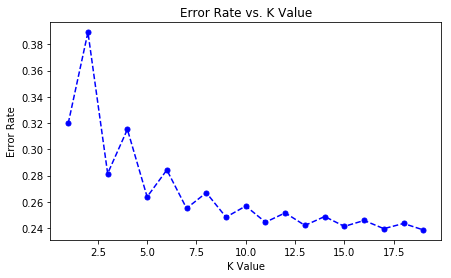

In [89]:
plt.figure(figsize=(7,4))
plt.plot(range(1,20),test_error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='blue',markersize=5)
plt.xlabel('K Value')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. K Value')

## Analysing the Results
The results show that considering K around 7-9 we should have balance between the test and train error rates. However, the results do not improve much more by adding the K value.

(Note: it was better to consider also the train error rate in this evaluation)


## The final model

Using the analysis, the K value of the KNN classifier is considered to be 9. I would retrain the model with this tuned parameter to compare the results.

In [102]:
knn9 = KNeighborsClassifier(n_neighbors=9)
knn9.fit(knn_X_train,knn_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform')

In [103]:
knn9_predictions = knn9.predict(knn_X_test)
print(confusion_matrix(knn_y_test,knn9_predictions))
print(classification_report(knn_y_test,knn9_predictions))

[[ 2976  9617]
 [ 3118 35582]]
             precision    recall  f1-score   support

          0       0.49      0.24      0.32     12593
          1       0.79      0.92      0.85     38700

avg / total       0.71      0.75      0.72     51293



In [104]:
knn9_predictions_probs = knn9.predict_proba(knn_X_test)

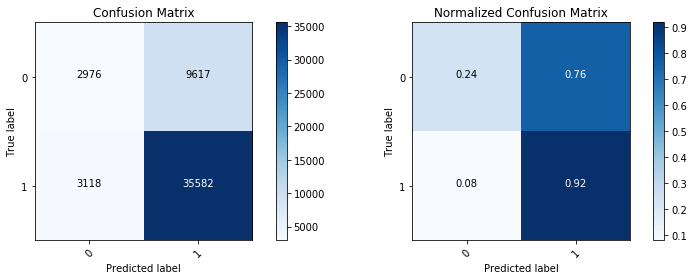

In [105]:
plot_side_by_side_confusion_matrix(knn_y_test,knn9_predictions)

No handles with labels found to put in legend.


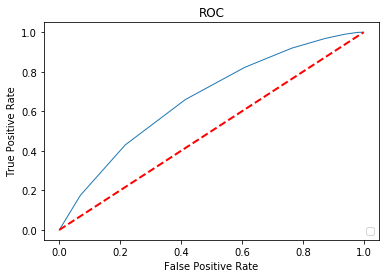

In [106]:
plot_roc_curve(knn_y_test, knn9_predictions_probs[:,1])

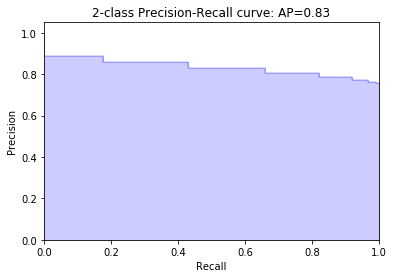

In [107]:
plot_precision_recall_curve(knn_y_test, knn9_predictions_probs[:,1])

## Analysing the Results

The final results show that the precision and recall have imprived significantly. Also the model seem to better predict the non-police attendance targets (considering the improved precision on non police attendence target).

## Report

### The Approach (Algorithms and Tools)

I mainly used the standard Python libraries: Numpy and Pandas for data analysis, Scikit-Learn for machine learning, and Seaborn and Matplotlib for data visualizations.

I started by looking at the data and ran some exploratory data analysis to understand the features and their relationships with eachother and with the target. At the next step, I preprocessed, cleaned and prepared the data for being used in fitting the models.

To choose a model, first considering that it was a classification problem I took a look on the classification models (Linear SVC, KNN Classifier, SVC, Random Forests, and AdaBoost). I started with the simplest model (Linear SVC) considering that there have been considerable amount of data and features to train. As the results of the Linear SVC were not satisfying (also after trying the Balanced Sampling and the GridSearchCV to tune the model), I moved to the next model on my list which was the KNN classifier. KNN Classifier provided better precision and recal, however the performance suffers because of many features used in the training.



### What were the main challenges?

The main challenges were the following:
- understanding and analysing the data
- selecting the features to be used
- cleaning and preparing the data
- finding the right model 
- training the models was time consuming, and therefore, there was not much chance to experiment

### What insight did you gain from working with the data?
The features don't seem to have significant correlation with the target. 

### How useful is the model?

The Linear SVC model provides acceptable precision and recall after tuning the 'C' parameter value. The KNN classifier instead provides better precision and recall but suffers on the performance because of the presence of many features.

### What might you do differently if you had more time/resource?

I would look at the other related data to see if there are features that can better determine the target. To increase the performance of the KNN classifier, some more features can be removed. Moreover, I would go on analysing other models to understand if any of them would perform better.